In [1]:
import os
# Suppress TensorFlow logging messages (set log level to only show errors)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
# 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR only

import warnings
# Ignore Python warnings to keep the output clean
warnings.filterwarnings('ignore')

import tensorflow as tf
# Suppress TensorFlow’s internal logger (only show ERROR-level messages)
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# ===============================
# LOAD DATASETS (real + synthetic)
# ===============================
# Each CSV contains time-series strain data (one row per sample)
# - signal_real  : Real noise with injected GW signals
# - signal_syn   : Synthetic noise with injected GW signals
# - noise_real   : Pure real noise segments
# - noise_syn    : Pure synthetic noise segments
signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

# ===============================
# ASSIGN BINARY LABELS
# ===============================
# Label convention:
# 1 = contains gravitational wave signal
# 0 = pure noise
signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

# ===============================
# MERGE INTO SINGLE TRAINING DATASET
# ===============================
# Combine all samples into one dataset
train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis = 0)
# Shuffle rows to mix signals and noise (reproducible with random_state=42)
train_data = shuffle(train_data, random_state = 42)

# ===============================
# SEPARATE FEATURES AND LABELS
# ===============================
# X = strain time series (all columns except label)
# y = binary labels (last column)
X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

# ===============================
# NORMALIZATION (based only on NOISE)
# ===============================
# Important: scale using only noise statistics
# This avoids signal "information leakage" into scaling
noise_all = pd.concat([noise_real, noise_syn], axis = 0)

scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])   # Fit scaler using pure noise
X = scaler.transform(X)              # Transform entire dataset

# ===============================
# RESHAPE FOR CNN INPUT
# ===============================
# Expand dimension to match Conv1D input: (samples, timesteps, 1 channel)
X = np.expand_dims(X, axis=-1)

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, Conv1D, MaxPooling1D,
    GlobalAveragePooling1D, Add, MultiHeadAttention, BatchNormalization
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ====================================================
# PREPROCESSING
# ====================================================
scaler = StandardScaler()
# Flatten last dim -> normalize across samples -> expand back to (N, 16384, 1)
X_scaled = scaler.fit_transform(X.squeeze(-1))  # Shape: (N, 16384)
X_scaled = X_scaled[..., np.newaxis]            # Shape: (N, 16384, 1)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ====================================================
# TRANSFORMER BLOCK
# ====================================================
def transformer_block(x, head_size=32, num_heads=2, ff_dim=64, dropout=0.1):
    """
    One transformer encoder block:
    - Multi-head self-attention
    - Residual connection + LayerNorm
    - Feed-forward network (2-layer MLP)
    - Residual connection + LayerNorm
    """
    # ---- Self-attention ----
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    x = Add()([x, attn])                     # Residual connection
    x = LayerNormalization()(x)              # Normalize for stability

    # ---- Feed-forward network ----
    ff = Dense(ff_dim, activation='relu')(x) # Expand hidden dimension
    ff = Dense(x.shape[-1])(ff)              # Project back to input size
    x = Add()([x, ff])                       # Residual connection
    x = LayerNormalization()(x)
    return x

# ====================================================
# MODEL BUILDER
# ====================================================
def build_cnn_transformer(input_shape=(16384, 1)):
    inp = Input(shape=input_shape)

    # ----- CNN feature extractor -----
    # First Conv block (reduce time resolution)
    x = Conv1D(32, 16, strides=4, padding='same')(inp)   # (16384 -> 4096, 32 filters)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)                     # (1024, 32)

    x = Conv1D(64, 8, strides=2, padding='same')(x)      # (512, 64)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)                     # (256, 64)

    # ----- Transformer block -----
    # Captures long-range dependencies after CNN compression
    x = transformer_block(x, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)

    # ----- Classification head -----
    x = GlobalAveragePooling1D()(x)   # Collapse sequence dimension -> vector
    x = Dropout(0.3)(x)               # Regularization
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x) # Binary classification (signal vs noise)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),   # Stable LR for transformers
        loss='binary_crossentropy',                 # Binary classification loss
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Accuracy + ROC-AUC
    )
    return model

# ====================================================
# TRAINING
# ====================================================
model = build_cnn_transformer()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8, # Small batch since transformers are memory-heavy
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# ====================================================
# EVALUATION
# ====================================================
y_pred = model.predict(X_val).ravel()

Epoch 1/50
1792/1792 [==============================] - 32s 14ms/step - loss: 0.7089 - accuracy: 0.4976 - auc: 0.5002 - val_loss: 0.6935 - val_accuracy: 0.5092 - val_auc: 0.5254
Epoch 2/50
1792/1792 [==============================] - 25s 14ms/step - loss: 0.6988 - accuracy: 0.5017 - auc: 0.5052 - val_loss: 0.6928 - val_accuracy: 0.5162 - val_auc: 0.5390
Epoch 3/50
1792/1792 [==============================] - 26s 14ms/step - loss: 0.6976 - accuracy: 0.5026 - auc: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.5162 - val_auc: 0.5335
Epoch 4/50
1792/1792 [==============================] - 27s 15ms/step - loss: 0.6960 - accuracy: 0.5013 - auc: 0.5055 - val_loss: 0.6933 - val_accuracy: 0.5067 - val_auc: 0.5701
Epoch 5/50
1792/1792 [==============================] - 27s 15ms/step - loss: 0.6954 - accuracy: 0.5057 - auc: 0.5097 - val_loss: 0.6904 - val_accuracy: 0.5053 - val_auc: 0.6511
Epoch 6/50
1792/1792 [==============================] - 27s 15ms/step - loss: 0.4744 - accuracy: 0.7317 - auc:

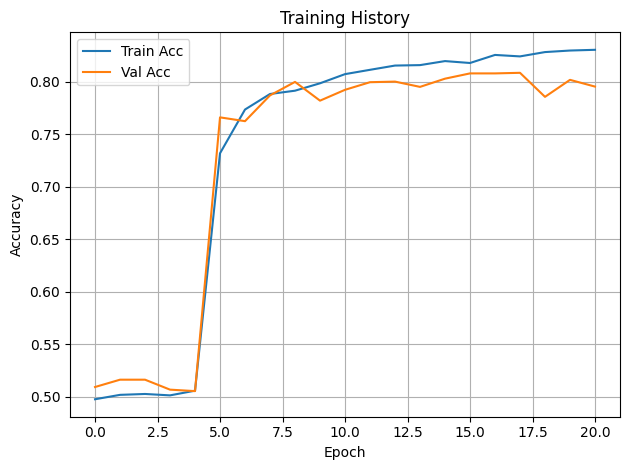

ROC AUC Score: 0.9128271608936543
              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      1792
         1.0       0.91      0.68      0.78      1792

    accuracy                           0.81      3584
   macro avg       0.83      0.81      0.80      3584
weighted avg       0.83      0.81      0.80      3584


Confusion Matrix (counts):
[[1671  121]
 [ 568 1224]]

Rates:
  TPR (Recall)      : 0.6830
  FPR               : 0.0675
  TNR (Specificity) : 0.9325
  FNR               : 0.3170


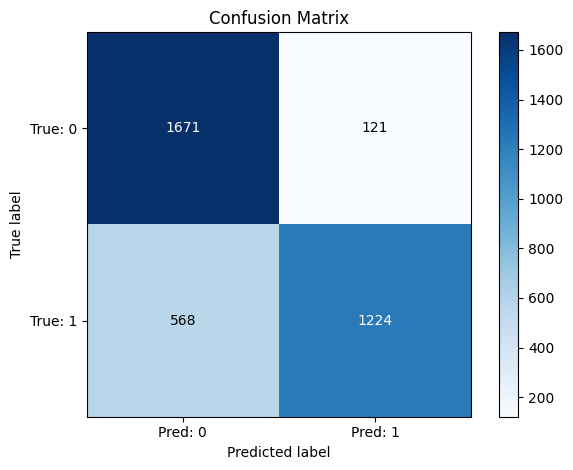

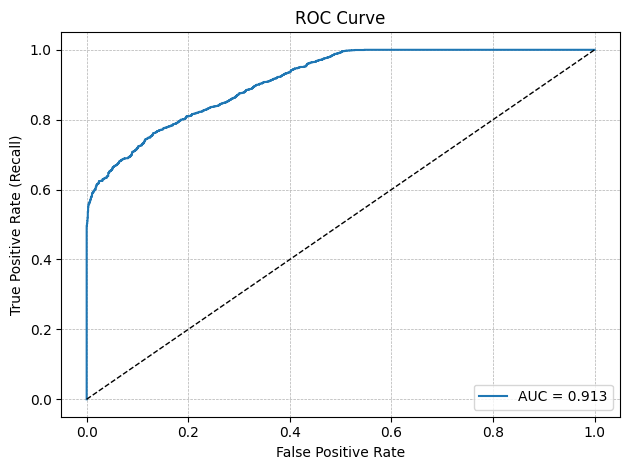

Gini Coefficient: 0.8257
Jaccard Score: 0.6398


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    jaccard_score
)

# Accuracy history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Core text metrics
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

#Confusion matrix + rates
y_pred_labels = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_labels)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix (counts):")
print(cm)

# Rates
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall / Sensitivity
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Specificity
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

print("\nRates:")
print(f"  TPR (Recall)      : {tpr:.4f}")
print(f"  FPR               : {fpr:.4f}")
print(f"  TNR (Specificity) : {tnr:.4f}")
print(f"  FNR               : {fnr:.4f}")

# Confusion matrix heatmap
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Pred: 0", "Pred: 1"])
plt.yticks(ticks, ["True: 0", "True: 1"])

# draw numbers
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

#ROC curve + AUC + Gini
fpr_curve, tpr_curve, _ = roc_curve(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_pred)
gini = 2 * auc_val - 1

plt.figure()
plt.plot(fpr_curve, tpr_curve, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


print(f"Gini Coefficient: {gini:.4f}")

#Jaccard + Precision–Recall curve
jac = jaccard_score(y_val, y_pred_labels)
print(f"Jaccard Score: {jac:.4f}")

In [7]:
model.save("final_cnn_transformer_model.h5")